In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import multiprocessing as mp


In [78]:
def _parallel_mc(iter=1000):
    pool = mp.Pool(4)

    future_res = [pool.apply_async(sample) for _ in range(iter)]
    res = [f.get() for f in future_res]

    return res

In [153]:
r=0.05
sig=0.25
X0=100
K=100
def mlmc_gbm(l,Nl,T=1,M=2,Npl=10**4):
    '''
    Calculates payoff for European call with geometric brownian motion for underlying. 
    __Inputs__
    l=fine level
    Nl = desired samples of Yl at this level
    T=time period for SDE to be simulated over
    M=coarseness factor
    Npl=default samples per loop to break up Nl into manageable chunks
    
    __Outputs__
    suml=[d_Pl,d_Pl**2,Pl,Pl**2]
    Yl=sum of payoff differences between coarse and fine paths at this level
    Pl=sum of payoffs at fine level
    '''
    Nsteps=M**l #Number of fine steps
    dt=T/Nsteps
    sqrt_dt=np.sqrt(dt)
    num_rem=Nl #Initialise remaining samples for while loop
    suml=np.zeros(4)
    
    while (num_rem>0): #<---Parallelise this while loop
        N_loop=min(Npl,num_rem) #Break up Nl into manageable chunks of size Npl, until last iteration
        num_rem-=N_loop #On final iteration N_loop=num_rem, so num_rem will be=0 and 
                    #cause while loop to exit next time
        
        #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
        Xf=X0*np.ones(N_loop)
        Xc=X0*np.ones(N_loop)
        dWc=np.zeros(N_loop)
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0
                
        #Calculate payoffs etc.

        Xf-=K
        Xf[Xf<=0]=0
        P_l=np.exp(-0.05*T)*Xf #Payoff at fine level
        sum1=np.sum(P_l)
        sum2=np.sum(P_l**2)
        if l==0:
            suml+=np.array([sum1,sum2,sum1,sum2])
        else:
            Xc-=X0
            Xc[Xc<0]=0
            P_lm1=np.exp(-0.05*T)*Xc #Payoff at coarse level
            dP_l=P_l-P_lm1 #Payoff difference
            suml+=np.array([np.sum(dP_l),np.sum(dP_l**2),sum1,sum2])
    return suml

def N_opt(V,eps,L,M):
    '''
    This shouldn't change depending on alpha, but will change according to gamma.
    Beta is implicitly included in V, since Vl <= hl**beta.
    '''
    sqrt_h=np.sqrt(M**(np.arange(0,L+1)))
    sqrt_V=np.sqrt(V)
    return np.ceil((2/eps**2)*np.sum(sqrt_V*sqrt_h)*sqrt_V/sqrt_h)
    
def mlmc(mlmc_fn,eps,N0=10**3,M=2,T=1):
    '''
    Runs MLMC method for given mlmc_fn (e.g. mlmc_gbm) which returns an array of sums at each level: 
    suml=[d_Pl,d_Pl**2,Pl,Pl**2].
    __Inputs__
    mlmc_fn = function to call at a given level
    eps = desired accuracy
    N0 = default number of samples to use when initialising new level
    M=coarseness factor
    T=time period for SDE to be simulated over
    
    __Outputs__
    sums = array of sums of payoff differences between coarse and fine paths at each level and
           sum of payoffs at fine level, each column is a level
    N = final number of samples at each level
    '''
    L=2

    V=np.zeros(L+1) #Initialise variance vector of each levels' variance
    N=N0*np.ones(L+1) #Initialise num. samples vector of each levels' num. samples
    dN=N0*np.ones(L+1) #Initialise additional samples for this iteration vector for each level
    sums=np.zeros((4,L+1)) #Initialise sums array, each column is a level

    while (np.sum(dN)>0): #Loop until no additional samples asked for
        for l in range(L+1): 
            num=dN[l]
            if num>0: #If asked for additional samples...
                sums[:,l]+=mlmc_fn(l,int(num),T,M) #Call function which gives sums

        
        N+=dN #Increment samples taken counter for each level        
        V=np.maximum((sums[1,:]/N)-(sums[0,:]/N)**2,0) #Calculate variance based on updated samples
        Nl_new=N_opt(V,eps,L,M) #Estimate optimal number of samples at each level
        dN=np.maximum(0,Nl_new-N) #Number of additional samples
        if sum(dN > 0.01*N) == 0:
            rem=abs(sums[0,-1])/N[L]
            if rem>eps*np.sqrt(0.5):
                L+=1
                #Add extra entries for the new level and estimate sums with N0 samples 
                V=np.concatenate((V,np.zeros(1)), axis=0)
                N=np.concatenate((N,N0*np.ones(1)),axis=0)
                dN=np.concatenate((dN,N0*np.ones(1)),axis=0)
                sums=np.concatenate((sums,np.zeros((4,1))),axis=1)
                sums[:,L]+=mlmc_fn(L,N0,T,M)
    
    return sums,N


____eps____
____eps____
____eps____
____eps____
____eps____


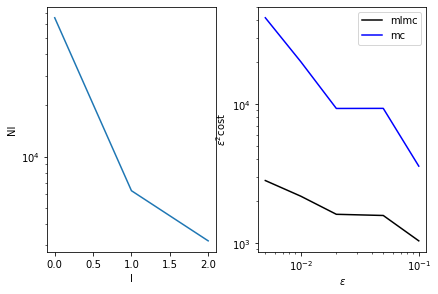

In [154]:
mlmc_complexity(mlmc_gbm,[0.005,0.01,0.02,0.05,0.1])

In [155]:
def mlmc_variance(mlmc_fn,eps,M=2,T=1,N0=10**3):
    sums,N=mlmc(mlmc_fn,eps,N0,M,T)
    L=len(N)-1
    means_dp=sums[0,:]/N
    means_p=sums[2,:]/N

    V_dp=(sums[1,:]/N)-means_dp**2
    V_p=(sums[3,:]/N)-means_p**2

    cost_mlmc=(N[0]+sum(N[1:]*(M**np.arange(L)+M**np.arange(1,L+1))))*eps**2
    cost_mc=2*sum(V_p*M**np.arange(L+1))
    
    fig,ax=plt.subplots(1,2)
    ax[0].plot(range(L+1),np.log(V_dp)/np.log(M),'k',range(L+1),np.log(V_p)/np.log(M),'b')
    ax[0].set_xlabel('$l$')
    ax[0].set_ylabel('log$_{M}$var')
    ax[0].legend(['mlmc','mc'])
    
    ax[1].plot(range(L+1),np.log(means_dp)/np.log(M),'k',range(L+1),np.log(means_p)/np.log(M),'b')
    ax[1].set_xlabel('$l$')
    ax[1].set_ylabel('log$_{M}$mean')
    ax[1].legend(['mlmc','mc'])

def mlmc_complexity(mlmc_fn,eps,M=2,T=1,N0=10**3):
    fig,ax=plt.subplots(1,2)
    fig.tight_layout()
    cost_mlmc=[]
    cost_mc=[]
    for e in eps:
        sums,N=mlmc(mlmc_fn,e,N0,M,T)
        L=len(N)-1
        means_p=sums[2,:]/N
        V_p=(sums[3,:]/N)-means_p**2

        cost_mlmc+=[(N[0]+sum(N[1:]*(M**np.arange(L)+M**np.arange(1,L+1))))*e**2]
        cost_mc+=[2*sum(V_p*M**np.arange(L+1))]

    ax[0].semilogy(range(L+1),N)
    ax[0].set_xlabel('l')
    ax[0].set_ylabel('Nl')

    ax[1].loglog(eps,cost_mlmc,'k', eps, cost_mc,'b')
    ax[1].set_xlabel('$\epsilon$')
    ax[1].set_ylabel('$\epsilon^{2}$cost')
    ax[1].legend(['mlmc','mc'])

In [ ]:
#### Exact result according to BS formula
D1 =(r+sig**2/2)/sig
D2 = D1 - sig
print(100*norm.cdf(D1)-100*np.exp(-r)*norm.cdf(D2))
